In [71]:
%matplotlib inline

In [72]:
import pandas as pd
import numpy as np
import tweepy
import re
import json
from datetime import datetime
import requests
import os
from matplotlib import pyplot as plt
import seaborn as sns

# Gather

In [73]:
pd.set_option('display.max_colwidth',1000)
tweets = pd.read_csv('twitter-archive-enhanced.csv') # File downloaded manually and stored locally.

In [74]:
tweets.shape

(2356, 17)

In [75]:
# File downloaded programmatically from Udacity's servers using the requests library.
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

with open ('image_predictions.tsv', 'wb') as file: # Create and open file to write to.
    file.write(r.content)

image_predictions = pd.read_table('image_predictions.tsv', sep='\t')

In [76]:
image_predictions.shape

(2075, 12)

In [ ]:
# Download tweet information Twitter using Twitter's API and the tweepy library.
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
user = api.get_user('dog_rates')    

In [ ]:
error_ids = [] # Append any tweet_ids that lead to errors.
tweet_info = [] # Each tweet's infomation to be appended to list as json object.

with open('tweet_json.txt', 'w') as file:
    for tweet_id in tweets['tweet_id']:
        tweet = {}
        try:
            status = api.get_status(tweet_id, tweet_mode='extended')
            tweet['id'] = status._json['id']
            tweet['favorite_count'] = status._json['favorite_count']
            tweet['retweet_count'] = status._json['retweet_count']
            tweet_info.append(tweet)
        
        except tweepy.TweepError:
            error_ids.append(tweet_id)
            continue
            
    json.dump(tweet_info, file, indent=4)


In [77]:
with open('tweet_json.txt', 'r') as fp:
    tweet_info = pd.read_json(fp)
          

In [78]:
tweet_info.shape

(2350, 3)

In [79]:
fav_and_rtwt = tweet_info.reindex(columns=['id', 'favorite_count', 'retweet_count'])
fav_and_rtwt.rename(columns={'id':'tweet_id'}, inplace=True)

In [80]:
tweets.tweet_id[~tweets.tweet_id.isin(fav_and_rtwt.tweet_id)]

19     888202515573088257
118    869988702071779329
155    861769973181624320
260    842892208864923648
566    802247111496568832
784    775096608509886464
Name: tweet_id, dtype: int64

In [81]:
# Merge tweets dataframe with fav_and_rtwt dataframe on tweet_id

tweets_merged = pd.merge(tweets, fav_and_rtwt, how='left', on='tweet_id')

In [82]:
tweets_merged.shape

(2356, 19)

In [83]:
tweets_merged[['tweet_id', 'timestamp', 'name', 'favorite_count', 'retweet_count', 'text']].sample(5)

,tweet_id,timestamp,name,favorite_count,retweet_count,text
2169,669353438988365824,2015-11-25 03:14:30 +0000,Tessa,688.0,279.0,This is Tessa. She is also very pleased after finally meeting her biological father. 10/10 https://t.co/qDS1aCqppv
1712,680494726643068929,2015-12-25 21:06:00 +0000,None,1865.0,540.0,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD
719,783391753726550016,2016-10-04 19:42:03 +0000,Godi,18790.0,6363.0,Meet Godi. He's an avid beachgoer and part time rainbow summoner. Eyeliner flawless af. 13/10 would snug well https://t.co/BO936YdJdi
470,816816676327063552,2017-01-05 01:20:46 +0000,Timber,11011.0,2341.0,This is Timber. He misses Christmas. Specifically the presents part. 12/10 cheer pup Timber https://t.co/dVVavqpeF9
1188,718454725339934721,2016-04-08 15:05:29 +0000,None,5277.0,1676.0,"This pic is old but I hadn't seen it until today and had to share. Creative af. 13/10 very good boy, would pet well https://t.co/4kD16wMA1Z"


# Assess

In [84]:
tweets_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
favorite_count                23

In [85]:
all_columns = pd.Series(list(image_predictions) + list(tweets_merged))
all_columns[all_columns.duplicated()]

12    tweet_id
dtype: object

In [86]:
len(tweets_merged[tweets_merged.expanded_urls.isnull()])

59

In [87]:
tweets_merged.loc[516, 'text']

'Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx'

In [88]:
tweets_merged.name.sample(15)

1533    Covach
1959      None
2092      None
1985    Cheryl
1938      None
398      Pablo
1441     Misty
1373      Fiji
1066      Chip
1006    Keurig
1918      None
2032      Mark
1755       Tug
607     Cooper
731      Combo
Name: name, dtype: object

In [89]:
tweets_merged.rating_denominator[tweets_merged.rating_denominator != 10].value_counts()

50     3
11     3
20     2
80     2
90     1
40     1
130    1
2      1
70     1
7      1
110    1
170    1
120    1
15     1
16     1
150    1
0      1
Name: rating_denominator, dtype: int64

In [90]:
tweets_merged.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [91]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [92]:
image_predictions.sample(6)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
583,678800283649069056,https://pbs.twimg.com/media/CWuVQSLW4AAI3w9.jpg,1,Labrador_retriever,0.213673,True,beagle,0.146235,True,Airedale,0.122701,True
1139,729463711119904772,https://pbs.twimg.com/media/Ch-TXpFXAAAwPGf.jpg,1,German_shepherd,0.829307,True,Doberman,0.022500,True,basenji,0.021190,True
691,684200372118904832,https://pbs.twimg.com/media/CX7EkuHWkAESLZk.jpg,1,llama,0.681347,False,ram,0.120142,False,hog,0.043686,False
86,667517642048163840,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg,1,Italian_greyhound,0.125176,True,standard_poodle,0.084572,True,cocker_spaniel,0.081347,True
533,676897532954456065,https://pbs.twimg.com/media/CWTSt0UW4AALMNB.jpg,1,hamster,0.628255,False,guinea_pig,0.318646,False,macaque,0.013058,False
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True


In [93]:
false_predictions = image_predictions[(image_predictions.p1_dog == False)
                  & (image_predictions.p2_dog == False)
                  & (image_predictions.p3_dog == False)]

In [94]:
false_predictions.tweet_id.count()

324

In [95]:
image_predictions.p1.value_counts().nlargest(10)

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
chow                   44
Samoyed                43
toy_poodle             39
Pomeranian             38
cocker_spaniel         30
Name: p1, dtype: int64

In [96]:
image_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [97]:
tweets_merged.tweet_id.isin(image_predictions.tweet_id).value_counts()

True     2075
False     281
Name: tweet_id, dtype: int64

## Issues to fix.

### Quality (content)
**Tweets dataframe**
* Only want original tweets i.e no retweets and no replies.
* Wrong data type for timestamp column.
* Denominator ratings not equal to 10.
* Null expanded_urls.
* Null favorite and retweet counts.
* Incorrect dog names e.g 'such', 'a', 'an', 'the'. 
* `image_predictions` table has 2075 records while `tweets` table has 2356 records, meaning some records don't have corresponding image predictions.
* Wrong data type for favorite and retweet columns.
* Tweet at index 516 has no rating in text column. 



### Tidiness (structure)
* More than one dog 'state' column.
* Drop columns - retweeted  and reply columns.

# Clean
## Quality Issues

In [98]:
tweets_merged_clean = tweets_merged.copy()
image_predictions_clean = image_predictions.copy()

### Retweets and replies.

- Remove any tweets that were not original, that is, retweets or replies to other tweeter users.

- This also deals with the missing favorite and retweet counts as well as the null tweet_ids from the favorites and retweets table. This is due to those specific tweets being retweets thus are removed when retweets are dropped.

In [99]:
tweets_merged_clean = tweets_merged_clean[tweets_merged_clean.retweeted_status_id.isnull()] # drop retweets
tweets_merged_clean = tweets_merged_clean[tweets_merged_clean.in_reply_to_status_id.isnull()]# drop replies

tweets_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
favorite_count                2097 non-n

### Null expanded_urls
Three records with null expanded urls. Since they are not rewteets or replies and have all other information, no cleaning is necessary and these records can be left as they are.

In [100]:
tweets_merged_clean[tweets_merged_clean.expanded_urls.isnull()][['tweet_id', 'expanded_urls', 'source', 'text']]

,tweet_id,expanded_urls,source,text
375,828361771580813312,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Beebop and Doobert should start a band 12/10 would listen
707,785515384317313025,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Today, 10/10, should be National Dog Rates Day"
1445,696518437233913856,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my god 10/10 for every little hot dog pupper


### Wrong data types
* Change data type of timestamp column from object to datetime. 
* Change favorite_count and retweet_count to integers from floats.

In [101]:
# Change data types of favorite and retweet columns to int from floats.
tweets_merged_clean.timestamp = pd.to_datetime(tweets_merged_clean.timestamp, infer_datetime_format=True)
tweets_merged_clean.favorite_count = tweets_merged_clean.favorite_count.astype('int64')
tweets_merged_clean.retweet_count = tweets_merged_clean.retweet_count.astype('int64')

In [102]:
tweets_merged_clean[['tweet_id', 'timestamp', 'favorite_count', 'retweet_count']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 4 columns):
tweet_id          2097 non-null int64
timestamp         2097 non-null datetime64[ns]
favorite_count    2097 non-null int64
retweet_count     2097 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 81.9 KB


### Tweet at index 516
Tweet at index 516 has no rating in text column. Drop row from dataframe

In [103]:
tweets_merged_clean.drop([516], inplace=True)

In [104]:
tweets_merged_clean.tweet_id.count() # 1 less tweet after dropping row 516.

2096

### Denominators
Denominators should be 10 as the ratings were out of 10. Some tweets have other number groups that were picked up instead of the rating itself e.g 24/7 or 50/50. 

Use pattern matching to extract correct ratings from tweet and further extract denominator from rating.

In [105]:
tweets_merged_clean[tweets_merged_clean.rating_denominator != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50


In [106]:
tweets_merged_clean[tweets_merged_clean.rating_denominator != 10].tweet_id.count()

16

In [107]:
def denominator_clean(array):
    '''
    Search for number groups that match pattern.
    Use [-1] to return last group (this should work even when only one group is returned by pattern search)
    Return numbers after '/' for rating denominator.
    '''
    try:
        num = re.findall(r'([0-9.]+[/][0-9$]+)',array)[-1]
        denominator = num[num.index('/')+1:]
    except: # If no matches are found
        pass
    return int(denominator)

In [108]:
tweets_merged_clean.rating_denominator = tweets_merged_clean.text.apply(denominator_clean)

In [109]:
tweets_merged_clean[tweets_merged_clean.rating_denominator != 10].tweet_id.count()

11

The tweets below have rating denominators not equal to 10 because the pictures included more than one dog. 

In [110]:
tweets_merged_clean[tweets_merged_clean.rating_denominator != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
1635,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
1779,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120


### Numerators
Some of the rating numerators are incorrect, especially when there is more than one group that matches the regex pattern. These can be cleaned by returning the second group from the match.

Other numerators are high because tweet was of a picture of more than one dog. Such ratings will not be changed. 

In [111]:
# Similar function used to clean denominators, except edited to return the numerator instead.
# Function returns a float as some rating numerators are fractions instead of whole numbers. 

def numerator_clean(array):
    '''
    Get list of groups that match pattern.
    Use [-1] to return last group.
    Return numbers before '/' as rating numerator.
    '''
    try:
        num = re.findall(r'([0-9]+[.]?[0-9]*[/][0-9$]+)',array)[-1]
        numerator = num[:(num.index('/'))]
    except: # If no matches are found
        pass
    return float(numerator)

In [112]:
tweets_merged_clean.rating_numerator = tweets_merged_clean.text.apply(numerator_clean)

In [113]:
large_numerators = list(tweets_merged_clean.rating_numerator[tweets_merged_clean.rating_numerator > 15].index)

In [114]:
tweets_merged_clean.loc[large_numerators][['text', 'rating_numerator']]

,text,rating_numerator
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0
1635,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0


## Tidyness (structure) Issues
* More than one dog 'state' column.
* Drop columns - retweeted and reply columns.



### Drop columns - retweeted and reply columns.

In [115]:
to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id', 'retweeted_status_timestamp'] # columns to drop

tweets_merged_clean = tweets_merged_clean.drop(to_drop, axis=1)

In [116]:
list(tweets_merged_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'favorite_count',
 'retweet_count']

### Dog 'state' column
Create a 'state' column with dog states concatenated into a string, use `str.split` to split the string into individual values. Then use `set()` to drop duplicate values for each entry.

In [117]:
tweets_merged_clean['state'] = tweets_merged_clean[['doggo','floofer', 'pupper', 'puppo']].apply(
    lambda x: '{},{},{},{}'.format(x[0],x[1],x[2],x[3]), axis=1) # Concatenate columns into a new column 'state'.
tweets_merged_clean['state'] = tweets_merged_clean['state'].str.split(',') # Split values at ','.
tweets_merged_clean['state'] = tweets_merged_clean['state'].apply(set) # remove duplicate 'None' values.

In [118]:
def clean_state(array):
    ''' remove 'None' if more than 1 dog state. '''
    if len(array) > 1:
        array.remove('None')
    return list(array)

tweets_merged_clean.state = tweets_merged_clean.state.apply(clean_state)

In [119]:
tweets_merged_clean.state[tweets_merged_clean.state.apply(len) > 1]

191       [doggo, puppo]
200     [floofer, doggo]
460      [doggo, pupper]
531      [doggo, pupper]
575      [doggo, pupper]
705      [doggo, pupper]
733      [doggo, pupper]
889      [doggo, pupper]
956      [doggo, pupper]
1063     [doggo, pupper]
1113     [doggo, pupper]
Name: state, dtype: object

In [120]:
states_to_drop = ['doggo','floofer', 'pupper', 'puppo'] # drop original dog 'state' columns.
tweets_merged_clean = tweets_merged_clean.drop(states_to_drop, axis=1)

In [121]:
tweets_merged_clean[['tweet_id', 'text', 'state']].sample(10)

,tweet_id,text,state
90,874680097055178752,Meet Cash. He hath acquired a stick. A very good stick tbh. 12/10 would pat head approvingly https://t.co/lZhtizkURD,[None]
2040,671544874165002241,Interesting dog here. Very large. Purple. Manifests rainbows. Perfect teeth. No ears. Surprisingly knowledgable 6/10 https://t.co/QVaEMsB9tS,[None]
896,759099523532779520,Meet Toby. He has a drinking problem. Inflatable marijuana plant in the back is also not a good look. 7/10 cmon Toby https://t.co/Cim4DSj6Oi,[None]
559,803276597545603072,This is Winston. His selfie game is legendary. Will steal your girl with a single snap. 11/10 handsome as h*ck https://t.co/jxQhxoPsgL,[None]
1370,702321140488925184,Please enjoy this picture as much as I did. 12/10 https://t.co/7u8mM99Tj5,[None]
1258,710283270106132480,This is Gunner. He's a Figamus Newton. King of the peek-a-boo. Cool jeans. 11/10 https://t.co/ONuBILIYXZ,[None]
2154,669625907762618368,This is Penny. She's having fun AND being safe. 12/10 very responsible pup https://t.co/eqeWw67oU7,[None]
1624,684880619965411328,Here we have a basking dino pupper. Looks powerful. Occasionally shits eggs. Doesn't want the holidays to end. 5/10 https://t.co/DnNweb5eTO,[pupper]
287,838561493054533637,This is Walter. His owner has been watching all the Iditarod coverage and is convinced Walter can be a sled dog. 13/10 Walter isn't so sure https://t.co/0av1PEehFI,[None]
253,844704788403113984,This is Luna. It's her first time outside and a bee stung her nose. Completely h*ckin uncalled for. 13/10 where's the bee I just wanna talk https://t.co/2RYiLGHuPN,[None]


In [122]:
tweets_merged_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2096 non-null int64
timestamp             2096 non-null datetime64[ns]
source                2096 non-null object
text                  2096 non-null object
expanded_urls         2093 non-null object
rating_numerator      2096 non-null float64
rating_denominator    2096 non-null int64
name                  2096 non-null object
favorite_count        2096 non-null int64
retweet_count         2096 non-null int64
state                 2096 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 276.5+ KB


#### Merge `tweets` Dataframe with `image_predictions` dataframe
Instead of doing a `left join` and then filtering out records with null values, I merged using an`inner join` to only keep tweet_ids that were in both dataframes.

In [123]:
tweets_merged_clean.tweet_id.isin(image_predictions.tweet_id).value_counts()

True     1970
False     126
Name: tweet_id, dtype: int64

In [124]:
tweets_full = pd.merge(tweets_merged_clean, image_predictions, how='left', on='tweet_id')

In [125]:
tweets_full_clean = tweets_full[tweets_full.p1.notnull() == True] # Only tweets that have image predictions.


In [126]:
# At least one True classification as a dog.
tweets_full_clean = tweets_full_clean[(tweets_full_clean.p1_dog == True) |
                                     (tweets_full_clean.p2_dog == True) |
                                     (tweets_full_clean.p3_dog == True)]

In [127]:
tweets_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 1 to 2095
Data columns (total 22 columns):
tweet_id              1665 non-null int64
timestamp             1665 non-null datetime64[ns]
source                1665 non-null object
text                  1665 non-null object
expanded_urls         1665 non-null object
rating_numerator      1665 non-null float64
rating_denominator    1665 non-null int64
name                  1665 non-null object
favorite_count        1665 non-null int64
retweet_count         1665 non-null int64
state                 1665 non-null object
jpg_url               1665 non-null object
img_num               1665 non-null float64
p1                    1665 non-null object
p1_conf               1665 non-null float64
p1_dog                1665 non-null object
p2                    1665 non-null object
p2_conf               1665 non-null float64
p2_dog                1665 non-null object
p3                    1665 non-null object
p3_conf               166

In [128]:
tweets_full_clean.describe()

,tweet_id,rating_numerator,rating_denominator,favorite_count,retweet_count,img_num,p1_conf,p2_conf,p3_conf
count,1.665000e+03,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1.665000e+03
mean,7.394614e+17,11.296565,10.444444,9310.455856,2832.299099,1.214414,0.605734,0.137438,6.129107e-02
std,6.801496e+16,7.245585,6.263021,12895.708530,4894.148864,0.574108,0.266392,0.101625,5.193659e-02
min,6.660209e+17,0.000000,10.000000,81.000000,14.000000,1.000000,0.044333,0.000010,2.160900e-07
25%,6.775479e+17,10.000000,10.000000,2164.000000,645.000000,1.000000,0.379055,0.054790,1.593830e-02
50%,7.141414e+17,11.000000,10.000000,4426.000000,1431.000000,1.000000,0.606747,0.121377,4.990060e-02
75%,7.931808e+17,12.000000,10.000000,11671.000000,3235.000000,1.000000,0.853170,0.199396,9.466370e-02
max,8.921774e+17,165.000000,150.000000,132022.000000,78893.000000,4.000000,0.999984,0.467678,2.734190e-01


In [129]:
tweets_full_clean[['text', 'name', 'rating_numerator', 'p1', 'p1_dog', 'p2', 'p2_dog', 'p3', 'p3_dog']].head()

,text,name,rating_numerator,p1,p1_dog,p2,p2_dog,p3,p3_dog
1,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly,13.0,Chihuahua,True,Pekinese,True,papillon,True
2,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie,12.0,Chihuahua,True,malamute,True,kelpie,True
3,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla,13.0,paper_towel,False,Labrador_retriever,True,spatula,False
4,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",Franklin,12.0,basset,True,English_springer,True,German_short-haired_pointer,True
5,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,None,13.0,Chesapeake_Bay_retriever,True,Irish_terrier,True,Indian_elephant,False


### Storing

In [130]:
tweets_full_clean.to_csv('twitter_archive_master.csv') # Store DataFrame as a csv file.

# Insights

In [131]:
# I grouped the the data by p1, which is the most likely dog breed fro the neural network classifier. 
grouped = tweets_full_clean.groupby(by='p1')

In [132]:
# Top 10 dog breeds by count. And average rating for each dog breed. 

top_10_breeds = grouped.agg({'p1': 'count', 'rating_numerator': 'mean',
                             'favorite_count': 'mean', 'retweet_count': 'mean'}).sort_values('p1')[-10:]

top_10_breeds.index.rename('breed', inplace=True)
top_10_breeds = top_10_breeds.round(decimals=2)
top_10_breeds = top_10_breeds.rename(columns={'p1':'breed_count'})
top_10_breeds = top_10_breeds.reset_index()


Some insights from this grouped data are:

1. Golden retriever is the most common dog breed in the `WeRateDogs` twitter archive with an average rating of 12.31.
2. Of the top 10 most common dog breeds, the labrador retriever has the highest average rating of 13.90.
3. Samoyed has both the highest average favorite and retweet counts. 

In [133]:
top_10_breeds.sort_values('rating_numerator', ascending=False) 

,breed,breed_count,rating_numerator,favorite_count,retweet_count
8,Labrador_retriever,94,13.90,11811.56,3850.07
9,golden_retriever,136,12.31,12464.04,3683.01
3,Samoyed,40,11.70,13503.95,4581.85
4,chow,41,11.61,10084.46,2890.32
7,Pembroke,88,11.40,11246.50,3159.10
1,toy_poodle,37,11.05,6735.00,2492.59
0,malamute,29,10.90,8763.45,2559.41
2,Pomeranian,38,10.84,8087.87,2852.76
6,Chihuahua,78,10.62,8741.04,2841.87
5,pug,54,10.24,5897.91,1821.98


C:\Users\ONESIH\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Most Common Dog Breeds')

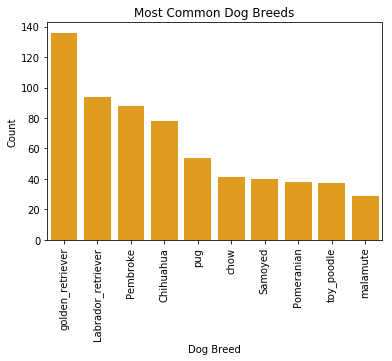

In [134]:
top_10_breeds = top_10_breeds.sort_values('breed_count', ascending=False) # Sort by breed counts desceding.

sns.barplot(top_10_breeds.breed, top_10_breeds.breed_count, color='orange')
plt.xticks(rotation=90)
plt.xlabel('Dog Breed')
plt.ylabel('Count')
plt.title('Most Common Dog Breeds')

C:\Users\ONESIH\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Ratings for Most Common Dog Breeds')

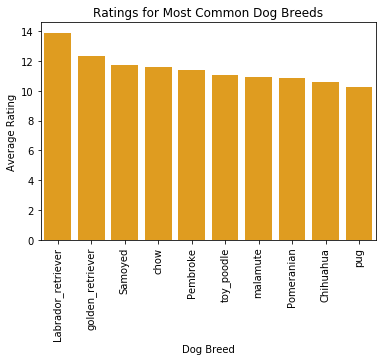

In [135]:
top_10_breeds = top_10_breeds.sort_values('rating_numerator', ascending=False) # Sort by rating descending.

sns.barplot(top_10_breeds.breed, top_10_breeds.rating_numerator, color='orange')
plt.xticks(rotation=90)
plt.xlabel('Dog Breed')
plt.ylabel('Average Rating')
plt.title('Ratings for Most Common Dog Breeds')